In [37]:
# Import statements and notebook settings
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

show_test_results = False

In [38]:
# Importing and reshaping data

(train_data, train_label), (test_data, test_label) = mnist.load_data()

if show_test_results:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))
        plt.show()

# assume all datasets have same dimensions
width = len(train_data[0])
height = len(train_data[0][0])
tot_pixels = width*height
num_labels = 10

# reshape data to fit AX = B. A = vectorized data, B = vectorized labels
train_A = np.zeros((len(train_data), tot_pixels))
train_B = np.zeros((len(train_label), num_labels))
for count, data in enumerate(train_data):
    train_A[count] = data.flatten()
    
    label_val = train_label[count]
    train_B[count][label_val] = 1

if show_test_results:
    for i in range(10):
        print(f"B: {train_B[i]}, label: {train_label[i]}")

KeyboardInterrupt: 

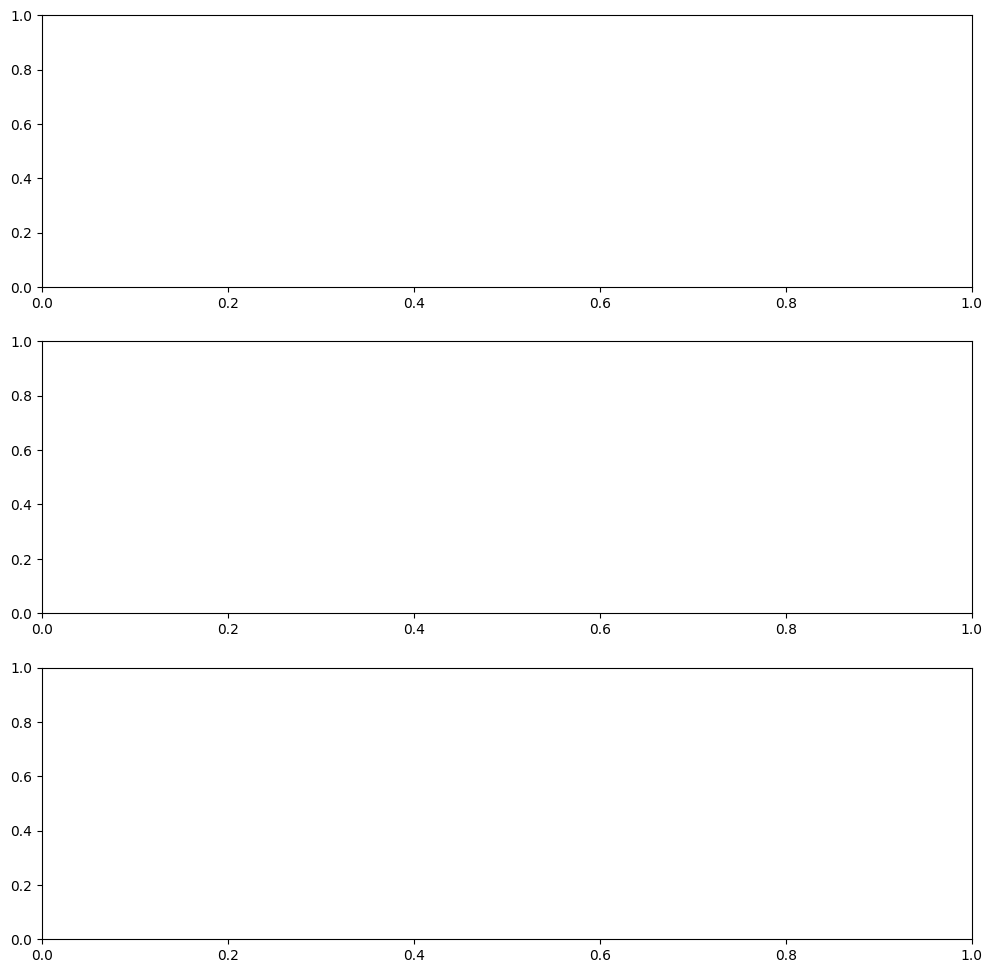

In [39]:
# solve AX=B to find pixels that map to correct label outcome
plt.rcParams['figure.figsize'] = [12, 12]

# Moore-Penrose pseudo-inverse to find init value
train_X0 = np.linalg.pinv(train_A)@train_B
train_X0 = train_X0.reshape(-1)     # vectorize

lam_array = np.array([0, 0.1, 0.5])

def one_norm_2d(x, A, b, lam, dim1, dim2):
    # scipy minimize does not work on multi-dim inputs
    # pass x as vector and resphape here
    x = np.reshape(x, (dim1, dim2))
    return np.linalg.norm(A@x-b,ord=2) + lam*np.linalg.norm(x,ord=1)

fig,axs = plt.subplots(len(lam_array),1)
for j, lam in enumerate(lam_array):
    res = minimize(one_norm_2d, 
                   args=(train_A, train_B, lam, tot_pixels, num_labels), 
                   x0 = train_X0)
    x = res.x
    x = x.reshape(tot_pixels, num_labels)
    x_pcolor = axs[j].pcolor(x.T,cmap='hot')
    fig.colorbar(x_pcolor, ax=axs[j])
    axs[j].set_ylabel(f"lam={lam}")

plt.show()